In [1]:
import h5py
import numpy as np

In [2]:
f = h5py.File('训练特征标签矩阵/训练矩阵A(no10).h5','r') 

In [3]:
Nuar = f['Nuar']  
Nuar = np.array(Nuar)
print(Nuar.shape)
label = f['label']   
label = np.array(label)
print(label.shape)

(395314, 16, 146)
(395314,)


In [4]:
Nuar = Nuar.reshape(395314,16,146,1)
Nuar.shape

(395314, 16, 146, 1)

In [5]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(Nuar,label,test_size=0.2,random_state=1)

In [6]:
print(X_train.shape)
print(X_test.shape)

(316251, 16, 146, 1)
(79063, 16, 146, 1)


In [7]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, 
Flatten,Dense, Lambda, Multiply, AveragePooling2D, Activation)
from tensorflow.keras.optimizers import Optimizer 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [8]:
import os
save_dir = '卷积神经网络模型'
os.makedirs(save_dir, exist_ok=True)
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15),
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_dir, 'chA(no10)模型.h5'), monitor='val_loss', save_best_only=True)]

In [9]:
def Conv2d_BN(x, nb_filter,kernel_size, padding='valid',strides=(1,1),data_format='channels_last',
              dilation_rate=(1,1),activation='relu',name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,data_format='channels_last',
               activation='relu',dilation_rate=dilation_rate,name=conv_name)(x)
    x = BatchNormalization(name=bn_name)(x)
    return x

In [10]:
def Conv2d_NB(x, nb_filter,kernel_size, padding='valid',strides=(1,1),data_format='channels_last',
              dilation_rate=(1,1),activation='relu',name=None):
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    x = BatchNormalization(name=bn_name)(x)
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,data_format='channels_last',
               activation='relu',dilation_rate=dilation_rate,name=conv_name)(x)
    x = BatchNormalization(name=bn_name)(x)
    return x

In [11]:
def InceptionA(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_1x3_t = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Activation('sigmoid')(branch_1x3_s)
    branch_1x3_c = keras.layers.Multiply()([branch_1x3_t,branch_1x3_s])
       
    branch_1x7_t = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x7_s = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x7_s = Activation('sigmoid')(branch_1x7_s)
    branch_1x7_c = keras.layers.Multiply()([branch_1x7_t,branch_1x7_s])
    
    branch_1x11_t = Conv2d_BN(x,nb_filter,(1,11), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',name=None)
    branch_1x11_s = Conv2d_BN(x,nb_filter,(1,11), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',name=None)
    branch_1x11_s = Activation('sigmoid')(branch_1x11_s)
    branch_1x11_c = keras.layers.Multiply()([branch_1x11_t,branch_1x11_s])
    
    branch_1x7_dt = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',
                              dilation_rate=(1,3),name=None)
    branch_1x7_ds = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',
                              dilation_rate=(1,3),name=None)
    branch_1x7_ds = Activation('sigmoid')(branch_1x7_ds)
    branch_1x7_dc = keras.layers.Multiply()([branch_1x7_dt,branch_1x7_ds])
    
    branch_1x11_dt = Conv2d_BN(x,nb_filter,(1,11), padding='same',strides=(1,1),
                               data_format='channels_last',activation='relu',
                               dilation_rate=(1,5),name=None)
    branch_1x11_ds = Conv2d_BN(x,nb_filter,(1,11), padding='same',strides=(1,1),
                               data_format='channels_last',activation='relu',
                               dilation_rate=(1,5),name=None)
    branch_1x11_ds = Activation('sigmoid')(branch_1x11_ds)
    branch_1x11_dc = keras.layers.Multiply()([branch_1x11_dt,branch_1x11_ds])

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_1x3_c,branch_1x7_c,
                                          branch_1x7_dc,branch_1x11_dc]) 
    return x

In [12]:
def InceptionB(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_1x3_t = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Activation('sigmoid')(branch_1x3_s)
    branch_1x3_c = keras.layers.Multiply()([branch_1x3_t,branch_1x3_s])
       
    branch_1x7_t = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x7_s = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                             data_format='channels_last',activation='relu',name=None)
    branch_1x7_s = Activation('sigmoid')(branch_1x7_s)
    branch_1x7_c = keras.layers.Multiply()([branch_1x7_t,branch_1x7_s])
    
    branch_1x7_dt = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',
                              dilation_rate=(1,3),name=None)
    branch_1x7_ds = Conv2d_BN(x,nb_filter,(1,7), padding='same',strides=(1,1),
                              data_format='channels_last',activation='relu',
                              dilation_rate=(1,3),name=None)
    branch_1x7_ds = Activation('sigmoid')(branch_1x7_ds)
    branch_1x7_dc = keras.layers.Multiply()([branch_1x7_dt,branch_1x7_ds])

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_1x3_c,branch_1x7_c,branch_1x7_dc]) #

    return x

In [13]:
def InceptionC(x,nb_filter):
    branch_1x1_t = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Conv2d_BN(x,nb_filter,(1,1), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x1_s = Activation('sigmoid')(branch_1x1_s)
    branch_1x1_c = keras.layers.Multiply()([branch_1x1_t,branch_1x1_s])
    
    branch_1x3_t = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',name=None)
    branch_1x3_s = Activation('sigmoid')(branch_1x3_s)
    branch_1x3_c = keras.layers.Multiply()([branch_1x3_t,branch_1x3_s])
    
    branch_1x3_dt = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',
                              dilation_rate=(1,2),name=None)
    branch_1x3_ds = Conv2d_BN(x,nb_filter,(1,3), padding='same',strides=(1,1),data_format='channels_last',activation='relu',
                              dilation_rate=(1,2),name=None)
    branch_1x3_ds = Activation('sigmoid')(branch_1x3_ds)
    branch_1x3_dc = keras.layers.Multiply()([branch_1x3_dt,branch_1x3_ds])

    x = keras.layers.Concatenate(axis=3)([branch_1x1_c,branch_1x3_c,branch_1x3_dc]) 
    return x

In [14]:
def TestNet(input_shape=None):
    inpt = Input(shape=input_shape)
    x = BatchNormalization()(inpt)
    x = InceptionA(x,64)
    x = MaxPooling2D(pool_size=(1,3),strides=(1,3),padding='valid',data_format='channels_last')(x)
    x = InceptionA(x,128)
    x = MaxPooling2D(pool_size=(1,3),strides=(1,3),padding='valid',data_format='channels_last')(x)
    x = InceptionB(x,128)
    x = MaxPooling2D(pool_size=(1,3),strides=(1,3),padding='valid',data_format='channels_last')(x)
    x = InceptionC(x,64)
    x = MaxPooling2D(pool_size=(1,3),strides=(1,3),padding='valid',data_format='channels_last')(x)
    x = Flatten(data_format='channels_last')(x)
    x = Dense(256,activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(32,activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(1,activation='relu')(x)
    model = Model(inpt,x,name='inception')
    return model

In [15]:
model = TestNet(input_shape=(16,146,1))
model.summary()

Model: "inception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 16, 146, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 146, 1)   4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 146, 64)  128         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 146, 64)  256         batch_normalization[0][0]        
__________________________________________________________________________________________

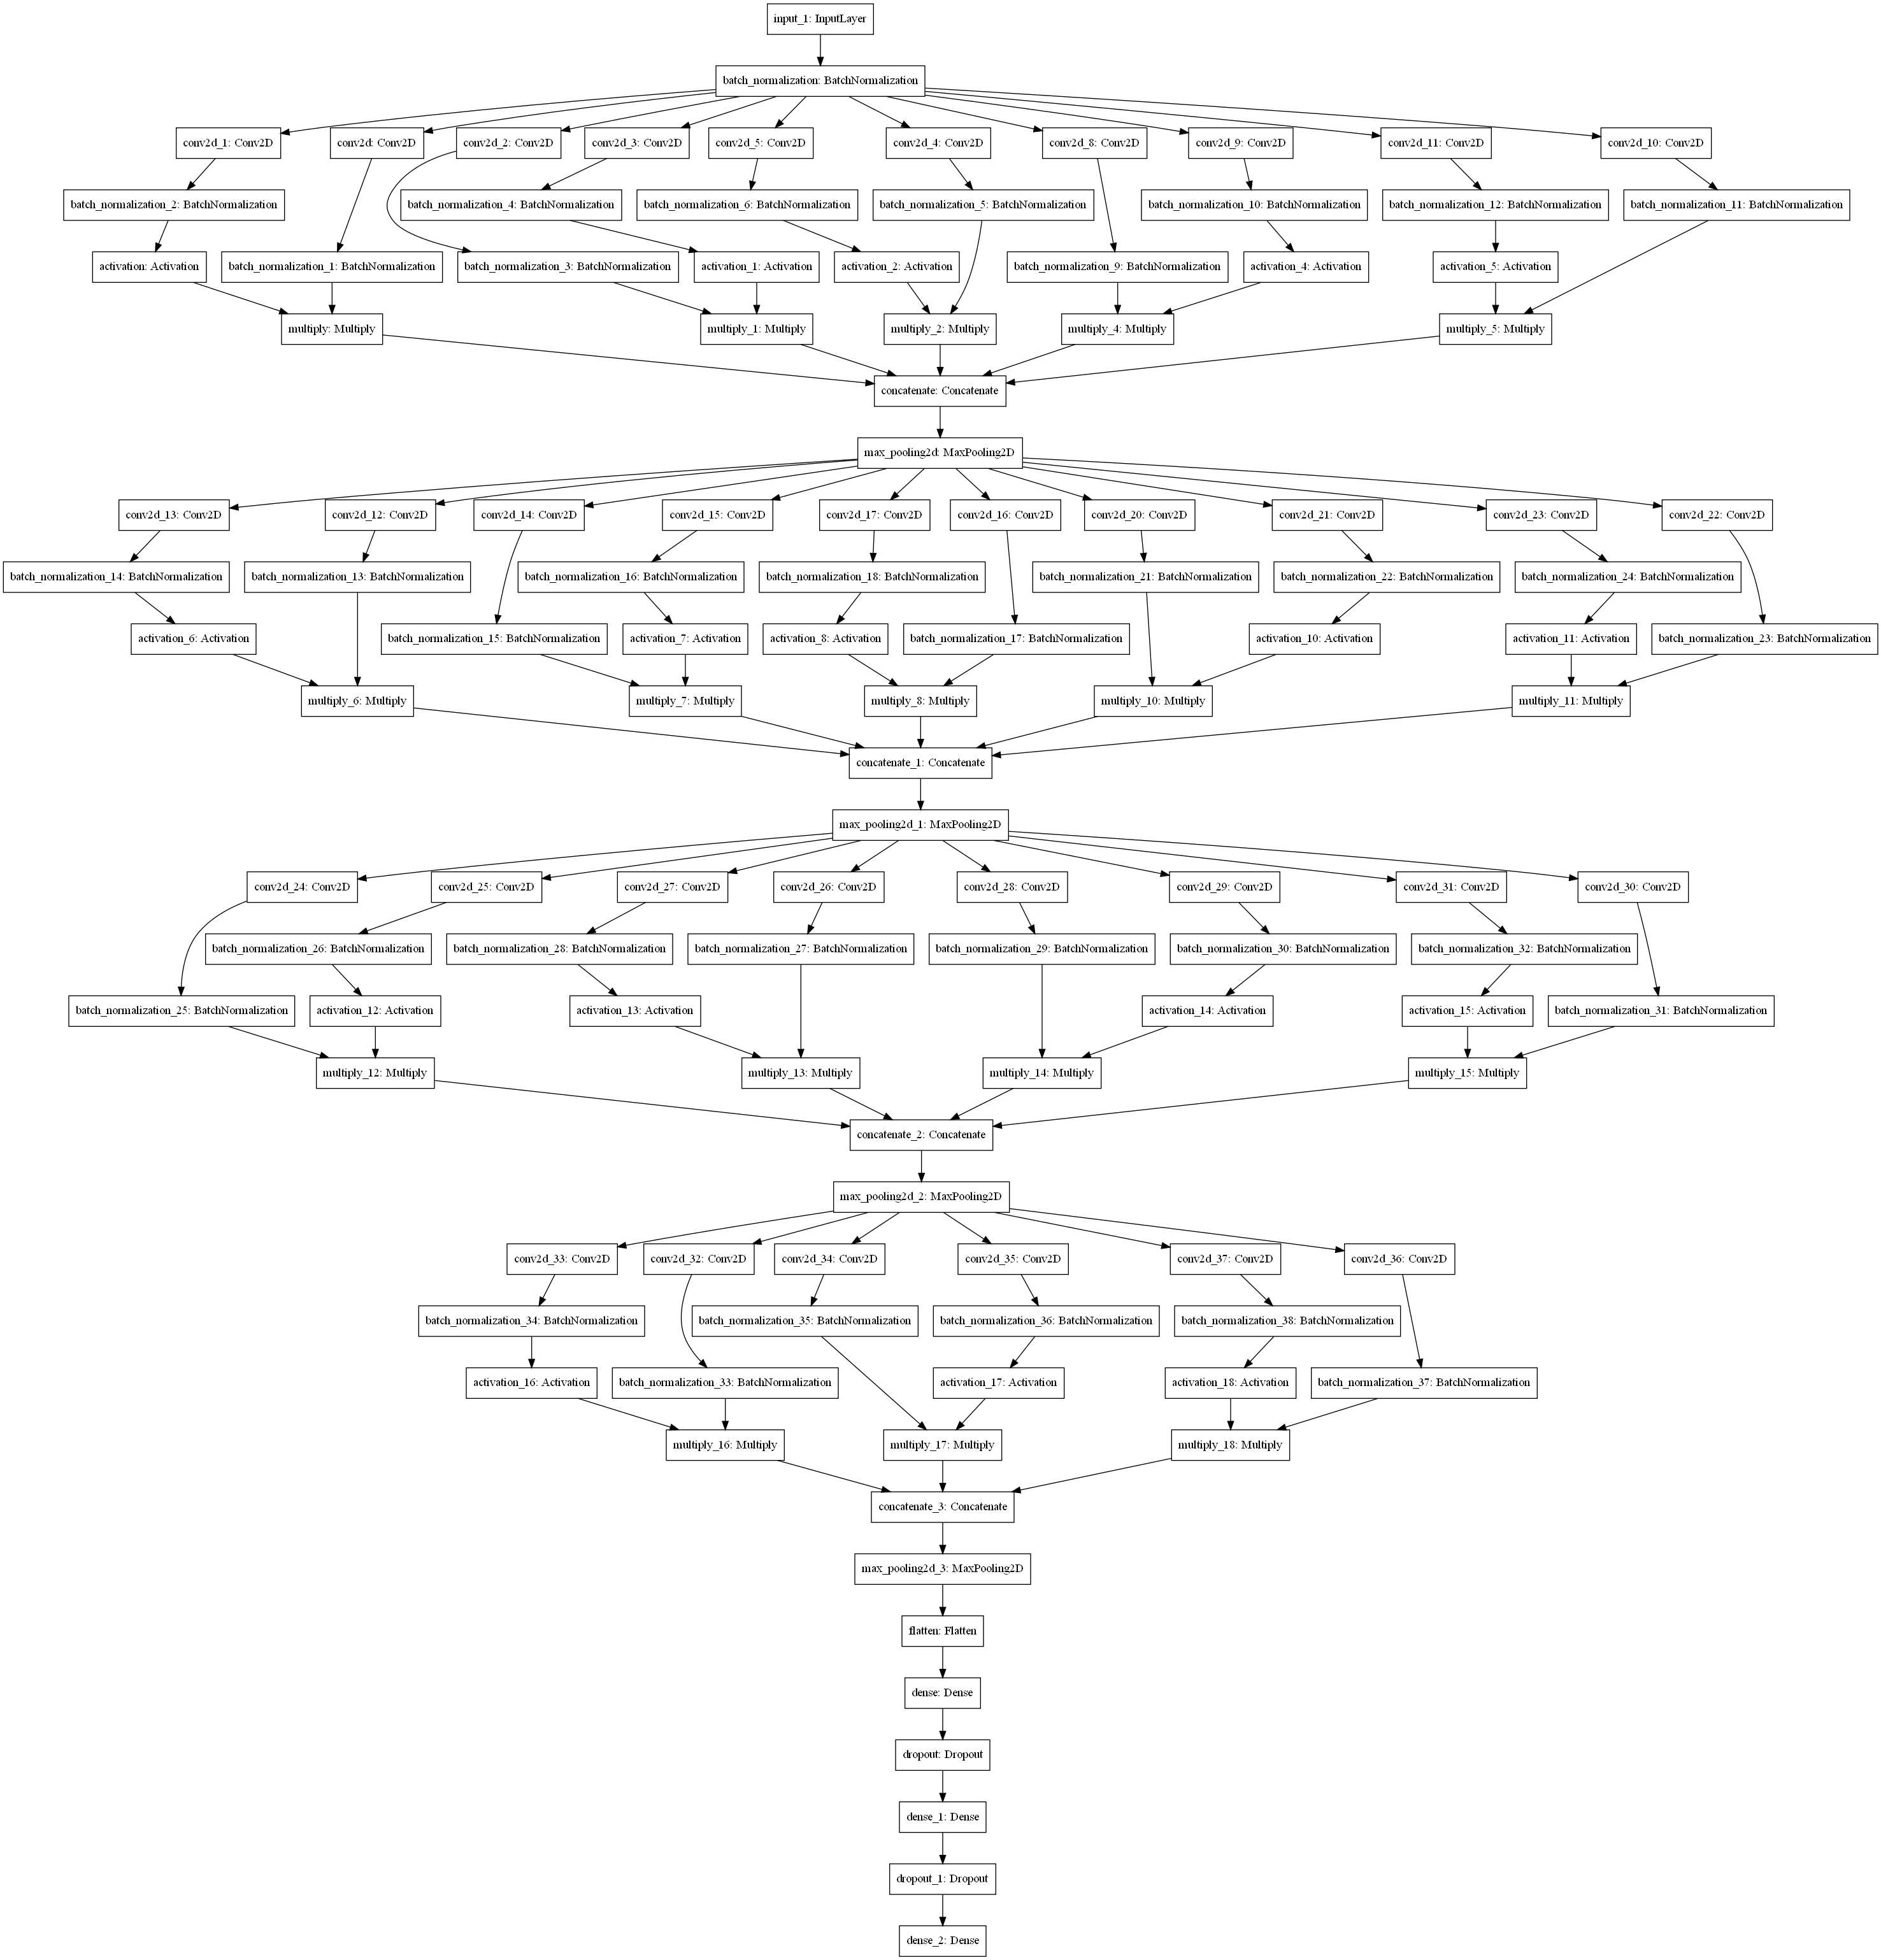

In [16]:
from tensorflow.keras.utils import plot_model    
plot_model(model,'可视化图/Model structure diagram.png')

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
model.compile(loss='mse',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['mae'])

In [18]:
model.load_weights('卷积神经网络模型/chA(no10)权重.h5')

In [21]:
model.fit(X_train,y_train,validation_split=0.25,epochs=10,batch_size=64,callbacks = callbacks_list)

Epoch 1/10
3707/3707 [==============================] - 329s 89ms/step - loss: 0.1257 - mae: 0.2711 - val_loss: 0.0933 - val_mae: 0.2265 - lr: 1.0000e-04
Epoch 2/10
3707/3707 [==============================] - 329s 89ms/step - loss: 0.1200 - mae: 0.2655 - val_loss: 0.0907 - val_mae: 0.2223 - lr: 1.0000e-04
Epoch 3/10
3707/3707 [==============================] - 330s 89ms/step - loss: 0.1148 - mae: 0.2605 - val_loss: 0.0898 - val_mae: 0.2215 - lr: 1.0000e-04
Epoch 4/10
3707/3707 [==============================] - 329s 89ms/step - loss: 0.1099 - mae: 0.2554 - val_loss: 0.0882 - val_mae: 0.2171 - lr: 1.0000e-04
Epoch 5/10
3707/3707 [==============================] - 330s 89ms/step - loss: 0.1064 - mae: 0.2515 - val_loss: 0.0871 - val_mae: 0.2153 - lr: 1.0000e-04
Epoch 6/10
3707/3707 [==============================] - 328s 89ms/step - loss: 0.1027 - mae: 0.2472 - val_loss: 0.0875 - val_mae: 0.2176 - lr: 1.0000e-04
Epoch 7/10
3707/3707 [==============================] - 328s 89ms/step - los

In [22]:
test_loss,test_mae= model.evaluate(X_test,y_test)
print('test_mae:',test_mae)                                

2471/2471 [==============================] - 46s 18ms/step - loss: 0.0866 - mae: 0.2156
test_mae: 0.21562224626541138


In [23]:
from tensorflow.keras.models import load_model
model1 = load_model('卷积神经网络模型/chA(no10)模型.h5')

In [24]:
test_loss,test_mae = model1.evaluate(X_test,y_test)
print('test_mae:',test_mae)

2471/2471 [==============================] - 46s 18ms/step - loss: 0.0866 - mae: 0.2153
test_mae: 0.2153245061635971
